In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
#from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
#from keras.applications.inception_v3 import InceptionV3
#from keras.applications.mobilenet import MobileNet
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.resnet50 import ResNet50
#from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import argparse


%matplotlib inline

In [4]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)

        img = cv2.imread(PATH)

        img = cv2.resize(img, (RESIZE,RESIZE))

        IMG.append(np.array(img))
    return IMG

In [5]:
#load data
early_blight_norm_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Normal',224))
early_blight_serious_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/EarlyBlight_Serious',224))
late_blight_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/LateBlight',224))
healthy_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Healthy',224))
insect_train = np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Insect',224))
lrv_train = np.array(Dataset_loader('/content/drive/MyDrive/potato1/train1/LeafRoll',224))
virus_train =np.array(Dataset_loader('/content/drive/My Drive/potato1/train1/Virus',224))

early_blight_norm_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Normal',224))
early_blight_serious_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/EarlyBlight_Serious',224))
late_blight_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/LateBlight',224))
healthy_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Healthy',224))
insect_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Insect',224))
lrv_test = np.array(Dataset_loader('/content/drive/MyDrive/potato1/test1/LeafRoll ',224))
virus_test = np.array(Dataset_loader('/content/drive/My Drive/potato1/test1/Virus',224))

100%|██████████| 200/200 [00:10<00:00, 18.55it/s]


In [6]:
print(len(lrv_test))

200


In [7]:
# Create labels
early_blight_norm_train_label = np.full(len(early_blight_norm_train),0)
early_blight_serious_train_label = np.full(len(early_blight_serious_train),1)
late_blight_train_label = np.full(len(late_blight_train),2)
virus_train_label = np.full(len(virus_train),3)
insect_train_label = np.full(len(insect_train),4)
lrv_train_label = np.full(len(lrv_train),5)
healthy_train_label = np.full(len(healthy_train),6)

early_blight_norm_test_label = np.full(len(early_blight_norm_test),0)
early_blight_serious_test_label = np.full(len(early_blight_serious_test),1)
late_blight_test_label = np.full(len(late_blight_test),2)
virus_test_label = np.full(len(virus_test),3)
insect_test_label = np.full(len(insect_test),4)
lrv_test_label = np.full(len(lrv_test),5)
healthy_test_label = np.full(len(healthy_test),6)

In [8]:
# Merge data
X_train = np.concatenate((early_blight_norm_train, early_blight_serious_train, late_blight_train, virus_train, insect_train, lrv_train, healthy_train), axis = 0)
Y_train = np.concatenate((early_blight_norm_train_label, early_blight_serious_train_label, late_blight_train_label, virus_train_label, insect_train_label, lrv_train_label, healthy_train_label), axis = 0)
X_test = np.concatenate((early_blight_norm_test, early_blight_serious_test, late_blight_test, virus_test, insect_test, lrv_test,  healthy_test), axis = 0)
Y_test = np.concatenate((early_blight_norm_test_label, early_blight_serious_test_label, late_blight_test_label, virus_test_label, insect_test_label, lrv_test_label, healthy_test_label), axis = 0)

In [9]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [10]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 7)
Y_test = to_categorical(Y_test, num_classes= 7)

In [11]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

In [12]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images

    )

In [13]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

ras      = ResNet50(include_top=False, input_shape=input_shape)(inputs)
dennet   = DenseNet201(include_top=False, input_shape=input_shape)(inputs)
vgg      = VGG16(include_top=False, input_shape=input_shape)(inputs)

58889256/58889256 [==============================] - 0s 0us/step


In [14]:
outputs = Concatenate(axis=-1)([GlobalAveragePooling2D()(ras), GlobalAveragePooling2D()(dennet), GlobalAveragePooling2D()(vgg)])
outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(128,activation='relu')(outputs)
outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(7, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.0001, decay=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 7, 7, 2048)           2358771   ['input_1[0][0]']             
                                                          2                                       
                                                                                                  
 densenet201 (Functional)    (None, 7, 7, 1920)           1832198   ['input_1[0][0]']             
                                                          4                                       
                                                                                              

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Drive/resDenseVgg16(7_classes)_old.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [16]:
history = model.fit(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=70,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/70
137/136 [==============================] - ETA: 0s - loss: 0.7178 - accuracy: 0.7389

136/136 [==============================] - 311s 2s/step - loss: 0.7178 - accuracy: 0.7389 - val_loss: 0.2132 - val_accuracy: 0.9250 - lr: 1.0000e-04
Epoch 2/70
137/136 [==============================] - ETA: 0s - loss: 0.3418 - accuracy: 0.8654

136/136 [==============================] - 201s 1s/step - loss: 0.3418 - accuracy: 0.8654 - val_loss: 0.0613 - val_accuracy: 0.9799 - lr: 1.0000e-04
Epoch 3/70
137/136 [==============================] - ETA: 0s - loss: 0.3121 - accuracy: 0.8796

136/136 [==============================] - 194s 1s/step - loss: 0.3121 - accuracy: 0.8796 - val_loss: 0.0485 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 4/70
137/136 [==============================] - ETA: 0s - loss: 0.2668 - accuracy: 0.8943

136/136 [==============================] - 201s 1s/step - loss: 0.2668 - accuracy: 0.8943 - val_loss: 0.0429 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 5/70
137/136 [==============================] - ETA: 0s - loss: 0.2373 - accuracy: 0.9050

136/136 [==============================] - 203s 1s/step - loss: 0.2373 - accuracy: 0.9050 - val_loss: 0.0486 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 6/70
137/136 [==============================] - ETA: 0s - loss: 0.2177 - accuracy: 0.9165

136/136 [==============================] - 203s 1s/step - loss: 0.2177 - accuracy: 0.9165 - val_loss: 0.0642 - val_accuracy: 0.9771 - lr: 1.0000e-04
Epoch 7/70
137/136 [==============================] - ETA: 0s - loss: 0.2137 - accuracy: 0.9162

136/136 [==============================] - 194s 1s/step - loss: 0.2137 - accuracy: 0.9162 - val_loss: 0.0474 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 8/70
137/136 [==============================] - ETA: 0s - loss: 0.1899 - accuracy: 0.9224

136/136 [==============================] - 201s 1s/step - loss: 0.1899 - accuracy: 0.9224 - val_loss: 0.0731 - val_accuracy: 0.9762 - lr: 1.0000e-04
Epoch 9/70
137/136 [==============================] - ETA: 0s - loss: 0.1902 - accuracy: 0.9302

136/136 [==============================] - 201s 1s/step - loss: 0.1902 - accuracy: 0.9302 - val_loss: 0.0407 - val_accuracy: 0.9854 - lr: 1.0000e-04
Epoch 10/70
137/136 [==============================] - ETA: 0s - loss: 0.1907 - accuracy: 0.9231

136/136 [==============================] - 203s 1s/step - loss: 0.1907 - accuracy: 0.9231 - val_loss: 0.0414 - val_accuracy: 0.9890 - lr: 1.0000e-04
Epoch 11/70
137/136 [==============================] - ETA: 0s - loss: 0.1873 - accuracy: 0.9261

136/136 [==============================] - 204s 1s/step - loss: 0.1873 - accuracy: 0.9261 - val_loss: 0.0711 - val_accuracy: 0.9744 - lr: 1.0000e-04
Epoch 12/70
137/136 [==============================] - ETA: 0s - loss: 0.1866 - accuracy: 0.9233

136/136 [==============================] - 203s 1s/step - loss: 0.1866 - accuracy: 0.9233 - val_loss: 0.0349 - val_accuracy: 0.9863 - lr: 1.0000e-04
Epoch 13/70
137/136 [==============================] - ETA: 0s - loss: 0.1656 - accuracy: 0.9359

136/136 [==============================] - 202s 1s/step - loss: 0.1656 - accuracy: 0.9359 - val_loss: 0.0596 - val_accuracy: 0.9826 - lr: 1.0000e-04
Epoch 14/70
137/136 [==============================] - ETA: 0s - loss: 0.1696 - accuracy: 0.9352

136/136 [==============================] - 195s 1s/step - loss: 0.1696 - accuracy: 0.9352 - val_loss: 0.0806 - val_accuracy: 0.9707 - lr: 1.0000e-04
Epoch 15/70
137/136 [==============================] - ETA: 0s - loss: 0.1657 - accuracy: 0.9323

136/136 [==============================] - 202s 1s/step - loss: 0.1657 - accuracy: 0.9323 - val_loss: 0.0485 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 16/70
137/136 [==============================] - ETA: 0s - loss: 0.1630 - accuracy: 0.9391

136/136 [==============================] - 203s 1s/step - loss: 0.1630 - accuracy: 0.9391 - val_loss: 0.0479 - val_accuracy: 0.9799 - lr: 1.0000e-04
Epoch 17/70
137/136 [==============================] - ETA: 0s - loss: 0.1562 - accuracy: 0.9387

136/136 [==============================] - 203s 1s/step - loss: 0.1562 - accuracy: 0.9387 - val_loss: 0.0347 - val_accuracy: 0.9863 - lr: 1.0000e-04
Epoch 18/70
137/136 [==============================] - ETA: 0s - loss: 0.1493 - accuracy: 0.9410

136/136 [==============================] - 201s 1s/step - loss: 0.1493 - accuracy: 0.9410 - val_loss: 0.0860 - val_accuracy: 0.9744 - lr: 1.0000e-04
Epoch 19/70
137/136 [==============================] - ETA: 0s - loss: 0.1438 - accuracy: 0.9405

136/136 [==============================] - 201s 1s/step - loss: 0.1438 - accuracy: 0.9405 - val_loss: 0.0281 - val_accuracy: 0.9881 - lr: 1.0000e-04
Epoch 20/70
137/136 [==============================] - ETA: 0s - loss: 0.1420 - accuracy: 0.9435

136/136 [==============================] - 203s 1s/step - loss: 0.1420 - accuracy: 0.9435 - val_loss: 0.1277 - val_accuracy: 0.9707 - lr: 1.0000e-04
Epoch 21/70
137/136 [==============================] - ETA: 0s - loss: 0.1669 - accuracy: 0.9325

136/136 [==============================] - 203s 1s/step - loss: 0.1669 - accuracy: 0.9325 - val_loss: 0.0539 - val_accuracy: 0.9762 - lr: 1.0000e-04
Epoch 22/70
137/136 [==============================] - ETA: 0s - loss: 0.1457 - accuracy: 0.9400

136/136 [==============================] - 203s 1s/step - loss: 0.1457 - accuracy: 0.9400 - val_loss: 0.0504 - val_accuracy: 0.9762 - lr: 1.0000e-04
Epoch 23/70
137/136 [==============================] - ETA: 0s - loss: 0.1419 - accuracy: 0.9453

136/136 [==============================] - 194s 1s/step - loss: 0.1419 - accuracy: 0.9453 - val_loss: 0.0437 - val_accuracy: 0.9854 - lr: 1.0000e-04
Epoch 24/70
137/136 [==============================] - ETA: 0s - loss: 0.1471 - accuracy: 0.9426

136/136 [==============================] - 203s 1s/step - loss: 0.1471 - accuracy: 0.9426 - val_loss: 0.0686 - val_accuracy: 0.9771 - lr: 1.0000e-04
Epoch 25/70
137/136 [==============================] - ETA: 0s - loss: 0.1546 - accuracy: 0.9396

136/136 [==============================] - 202s 1s/step - loss: 0.1546 - accuracy: 0.9396 - val_loss: 0.0645 - val_accuracy: 0.9744 - lr: 1.0000e-04
Epoch 26/70
137/136 [==============================] - ETA: 0s - loss: 0.1503 - accuracy: 0.9423

136/136 [==============================] - 203s 1s/step - loss: 0.1503 - accuracy: 0.9423 - val_loss: 0.0394 - val_accuracy: 0.9799 - lr: 1.0000e-04
Epoch 27/70
137/136 [==============================] - ETA: 0s - loss: 0.1348 - accuracy: 0.9501

136/136 [==============================] - 194s 1s/step - loss: 0.1348 - accuracy: 0.9501 - val_loss: 0.0437 - val_accuracy: 0.9872 - lr: 1.0000e-04
Epoch 28/70
137/136 [==============================] - ETA: 0s - loss: 0.1333 - accuracy: 0.9474

136/136 [==============================] - 202s 1s/step - loss: 0.1333 - accuracy: 0.9474 - val_loss: 0.0250 - val_accuracy: 0.9881 - lr: 1.0000e-04
Epoch 29/70
137/136 [==============================] - ETA: 0s - loss: 0.1352 - accuracy: 0.9478

136/136 [==============================] - 203s 1s/step - loss: 0.1352 - accuracy: 0.9478 - val_loss: 0.0247 - val_accuracy: 0.9899 - lr: 1.0000e-04
Epoch 30/70
137/136 [==============================] - ETA: 0s - loss: 0.1242 - accuracy: 0.9503

136/136 [==============================] - 203s 1s/step - loss: 0.1242 - accuracy: 0.9503 - val_loss: 0.0255 - val_accuracy: 0.9909 - lr: 1.0000e-04
Epoch 31/70
137/136 [==============================] - ETA: 0s - loss: 0.1341 - accuracy: 0.9501

136/136 [==============================] - 202s 1s/step - loss: 0.1341 - accuracy: 0.9501 - val_loss: 0.0492 - val_accuracy: 0.9790 - lr: 1.0000e-04
Epoch 32/70
137/136 [==============================] - ETA: 0s - loss: 0.1238 - accuracy: 0.9515

136/136 [==============================] - 194s 1s/step - loss: 0.1238 - accuracy: 0.9515 - val_loss: 0.0444 - val_accuracy: 0.9826 - lr: 1.0000e-04
Epoch 33/70
137/136 [==============================] - ETA: 0s - loss: 0.1332 - accuracy: 0.9503

136/136 [==============================] - 194s 1s/step - loss: 0.1332 - accuracy: 0.9503 - val_loss: 0.0533 - val_accuracy: 0.9808 - lr: 1.0000e-04
Epoch 34/70
137/136 [==============================] - ETA: 0s - loss: 0.1374 - accuracy: 0.9465

136/136 [==============================] - 202s 1s/step - loss: 0.1374 - accuracy: 0.9465 - val_loss: 0.0804 - val_accuracy: 0.9689 - lr: 1.0000e-04
Epoch 35/70
137/136 [==============================] - ETA: 0s - loss: 0.1234 - accuracy: 0.9522

136/136 [==============================] - 194s 1s/step - loss: 0.1234 - accuracy: 0.9522 - val_loss: 0.1200 - val_accuracy: 0.9680 - lr: 1.0000e-04
Epoch 36/70
137/136 [==============================] - ETA: 0s - loss: 0.1282 - accuracy: 0.9515

136/136 [==============================] - 203s 1s/step - loss: 0.1282 - accuracy: 0.9515 - val_loss: 0.0393 - val_accuracy: 0.9863 - lr: 1.0000e-04
Epoch 37/70
137/136 [==============================] - ETA: 0s - loss: 0.1143 - accuracy: 0.9540

136/136 [==============================] - 202s 1s/step - loss: 0.1143 - accuracy: 0.9540 - val_loss: 0.0265 - val_accuracy: 0.9899 - lr: 1.0000e-04
Epoch 38/70
137/136 [==============================] - ETA: 0s - loss: 0.1133 - accuracy: 0.9561

136/136 [==============================] - 204s 1s/step - loss: 0.1133 - accuracy: 0.9561 - val_loss: 0.0324 - val_accuracy: 0.9854 - lr: 1.0000e-04
Epoch 39/70
137/136 [==============================] - ETA: 0s - loss: 0.1189 - accuracy: 0.9542

136/136 [==============================] - 194s 1s/step - loss: 0.1189 - accuracy: 0.9542 - val_loss: 0.0289 - val_accuracy: 0.9909 - lr: 1.0000e-04
Epoch 40/70
137/136 [==============================] - ETA: 0s - loss: 0.1049 - accuracy: 0.9622

136/136 [==============================] - 194s 1s/step - loss: 0.1049 - accuracy: 0.9622 - val_loss: 0.0481 - val_accuracy: 0.9771 - lr: 1.0000e-04
Epoch 41/70
137/136 [==============================] - ETA: 0s - loss: 0.1262 - accuracy: 0.9542

136/136 [==============================] - 202s 1s/step - loss: 0.1262 - accuracy: 0.9542 - val_loss: 0.0387 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 42/70
137/136 [==============================] - ETA: 0s - loss: 0.1188 - accuracy: 0.9556

136/136 [==============================] - 203s 1s/step - loss: 0.1188 - accuracy: 0.9556 - val_loss: 0.0173 - val_accuracy: 0.9973 - lr: 1.0000e-04
Epoch 43/70
137/136 [==============================] - ETA: 0s - loss: 0.1150 - accuracy: 0.9586

136/136 [==============================] - 202s 1s/step - loss: 0.1150 - accuracy: 0.9586 - val_loss: 0.0864 - val_accuracy: 0.9689 - lr: 1.0000e-04
Epoch 44/70
137/136 [==============================] - ETA: 0s - loss: 0.1168 - accuracy: 0.9506

136/136 [==============================] - 203s 1s/step - loss: 0.1168 - accuracy: 0.9506 - val_loss: 0.0247 - val_accuracy: 0.9899 - lr: 1.0000e-04
Epoch 45/70
137/136 [==============================] - ETA: 0s - loss: 0.1147 - accuracy: 0.9547

136/136 [==============================] - 202s 1s/step - loss: 0.1147 - accuracy: 0.9547 - val_loss: 0.0258 - val_accuracy: 0.9899 - lr: 1.0000e-04
Epoch 46/70
137/136 [==============================] - ETA: 0s - loss: 0.1080 - accuracy: 0.9597

136/136 [==============================] - 194s 1s/step - loss: 0.1080 - accuracy: 0.9597 - val_loss: 0.0259 - val_accuracy: 0.9909 - lr: 1.0000e-04
Epoch 47/70
137/136 [==============================] - ETA: 0s - loss: 0.1215 - accuracy: 0.9517

136/136 [==============================] - 202s 1s/step - loss: 0.1215 - accuracy: 0.9517 - val_loss: 0.0316 - val_accuracy: 0.9854 - lr: 1.0000e-04
Epoch 48/70
137/136 [==============================] - ETA: 0s - loss: 0.1218 - accuracy: 0.9570

136/136 [==============================] - 203s 1s/step - loss: 0.1218 - accuracy: 0.9570 - val_loss: 0.0234 - val_accuracy: 0.9899 - lr: 1.0000e-04
Epoch 49/70
137/136 [==============================] - ETA: 0s - loss: 0.1101 - accuracy: 0.9588

136/136 [==============================] - 203s 1s/step - loss: 0.1101 - accuracy: 0.9588 - val_loss: 0.0188 - val_accuracy: 0.9927 - lr: 1.0000e-04
Epoch 50/70
137/136 [==============================] - ETA: 0s - loss: 0.1168 - accuracy: 0.9538

136/136 [==============================] - 202s 1s/step - loss: 0.1168 - accuracy: 0.9538 - val_loss: 0.0270 - val_accuracy: 0.9899 - lr: 1.0000e-04
Epoch 51/70
137/136 [==============================] - ETA: 0s - loss: 0.1190 - accuracy: 0.9551

136/136 [==============================] - 195s 1s/step - loss: 0.1190 - accuracy: 0.9551 - val_loss: 0.0430 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 52/70
137/136 [==============================] - ETA: 0s - loss: 0.1200 - accuracy: 0.9542

136/136 [==============================] - 203s 1s/step - loss: 0.1200 - accuracy: 0.9542 - val_loss: 0.0456 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 53/70
137/136 [==============================] - ETA: 0s - loss: 0.0993 - accuracy: 0.9643

136/136 [==============================] - 205s 1s/step - loss: 0.0993 - accuracy: 0.9643 - val_loss: 0.0518 - val_accuracy: 0.9863 - lr: 1.0000e-04
Epoch 54/70
137/136 [==============================] - ETA: 0s - loss: 0.0933 - accuracy: 0.9634

136/136 [==============================] - 205s 1s/step - loss: 0.0933 - accuracy: 0.9634 - val_loss: 0.0207 - val_accuracy: 0.9909 - lr: 1.0000e-04
Epoch 55/70
137/136 [==============================] - ETA: 0s - loss: 0.1207 - accuracy: 0.9542

136/136 [==============================] - 202s 1s/step - loss: 0.1207 - accuracy: 0.9542 - val_loss: 0.0382 - val_accuracy: 0.9863 - lr: 1.0000e-04
Epoch 56/70
137/136 [==============================] - ETA: 0s - loss: 0.1011 - accuracy: 0.9590

136/136 [==============================] - 202s 1s/step - loss: 0.1011 - accuracy: 0.9590 - val_loss: 0.0359 - val_accuracy: 0.9881 - lr: 1.0000e-04
Epoch 57/70
137/136 [==============================] - ETA: 0s - loss: 0.0994 - accuracy: 0.9586

136/136 [==============================] - 202s 1s/step - loss: 0.0994 - accuracy: 0.9586 - val_loss: 0.0261 - val_accuracy: 0.9872 - lr: 1.0000e-04
Epoch 58/70
137/136 [==============================] - ETA: 0s - loss: 0.1001 - accuracy: 0.9643

136/136 [==============================] - 204s 1s/step - loss: 0.1001 - accuracy: 0.9643 - val_loss: 0.0650 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 59/70
137/136 [==============================] - ETA: 0s - loss: 0.1086 - accuracy: 0.9574

136/136 [==============================] - 202s 1s/step - loss: 0.1086 - accuracy: 0.9574 - val_loss: 0.0609 - val_accuracy: 0.9817 - lr: 1.0000e-04
Epoch 60/70
137/136 [==============================] - ETA: 0s - loss: 0.1024 - accuracy: 0.9629

136/136 [==============================] - 202s 1s/step - loss: 0.1024 - accuracy: 0.9629 - val_loss: 0.0306 - val_accuracy: 0.9881 - lr: 1.0000e-04
Epoch 61/70
137/136 [==============================] - ETA: 0s - loss: 0.0947 - accuracy: 0.9625

136/136 [==============================] - 202s 1s/step - loss: 0.0947 - accuracy: 0.9625 - val_loss: 0.0638 - val_accuracy: 0.9799 - lr: 1.0000e-04
Epoch 62/70
137/136 [==============================] - ETA: 0s - loss: 0.0896 - accuracy: 0.9684

136/136 [==============================] - 203s 1s/step - loss: 0.0896 - accuracy: 0.9684 - val_loss: 0.0323 - val_accuracy: 0.9872 - lr: 1.0000e-04
Epoch 63/70
137/136 [==============================] - ETA: 0s - loss: 0.0842 - accuracy: 0.9721

136/136 [==============================] - 195s 1s/step - loss: 0.0842 - accuracy: 0.9721 - val_loss: 0.0237 - val_accuracy: 0.9881 - lr: 1.0000e-04
Epoch 64/70
137/136 [==============================] - ETA: 0s - loss: 0.1058 - accuracy: 0.9613

136/136 [==============================] - 204s 1s/step - loss: 0.1058 - accuracy: 0.9613 - val_loss: 0.0379 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 65/70
137/136 [==============================] - ETA: 0s - loss: 0.1028 - accuracy: 0.9572

136/136 [==============================] - 203s 1s/step - loss: 0.1028 - accuracy: 0.9572 - val_loss: 0.0281 - val_accuracy: 0.9872 - lr: 1.0000e-04
Epoch 66/70
137/136 [==============================] - ETA: 0s - loss: 0.0988 - accuracy: 0.9611

136/136 [==============================] - 201s 1s/step - loss: 0.0988 - accuracy: 0.9611 - val_loss: 0.0547 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 67/70
137/136 [==============================] - ETA: 0s - loss: 0.1046 - accuracy: 0.9616

136/136 [==============================] - 201s 1s/step - loss: 0.1046 - accuracy: 0.9616 - val_loss: 0.0723 - val_accuracy: 0.9799 - lr: 1.0000e-04
Epoch 68/70
137/136 [==============================] - ETA: 0s - loss: 0.1024 - accuracy: 0.9625

136/136 [==============================] - 194s 1s/step - loss: 0.1024 - accuracy: 0.9625 - val_loss: 0.0122 - val_accuracy: 0.9945 - lr: 1.0000e-04
Epoch 69/70
137/136 [==============================] - ETA: 0s - loss: 0.0898 - accuracy: 0.9645

136/136 [==============================] - 193s 1s/step - loss: 0.0898 - accuracy: 0.9645 - val_loss: 0.0191 - val_accuracy: 0.9954 - lr: 1.0000e-04
Epoch 70/70
137/136 [==============================] - ETA: 0s - loss: 0.0976 - accuracy: 0.9654

136/136 [==============================] - 202s 1s/step - loss: 0.0976 - accuracy: 0.9654 - val_loss: 0.0267 - val_accuracy: 0.9899 - lr: 1.0000e-04


47/47 [==============================] - 36s 646ms/step
Confusion matrix, without normalization
[[203   2   0   0   0   0   1]
 [  0 278   0   0   0   0   0]
 [  0   0 200   0   0   0   0]
 [  0   0   0 195   5   0   0]
 [  0   0   0   8 186  12   0]
 [  0   0   0   0   9 186   5]
 [  1   0   0   0   0   0 204]]


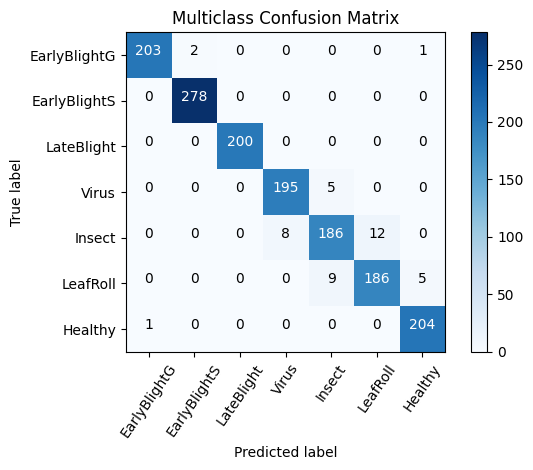

In [17]:
Y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['EarlyBlightG','EarlyBlightS', 'LateBlight', 'Virus' , 'Insect','LeafRoll', 'Healthy']
plot_confusion_matrix(cm, cm_plot_label, title ='Multiclass Confusion Matrix')

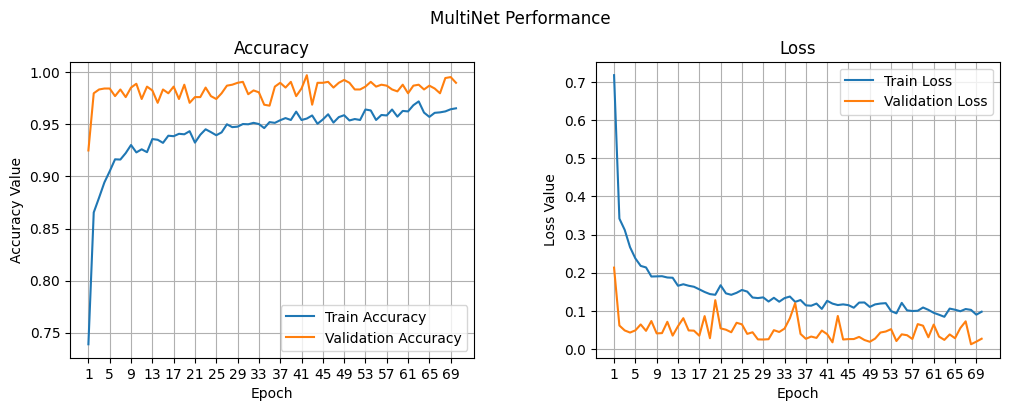

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('MultiNet Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,71))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 71, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 71, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [19]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['EarlyBlight General','EarlyBlight Serious', 'LateBlight','Virus' , 'Insect','LeafRoll','Healthy' ]
print(classification_report(y_test, Y_pred, target_names=target_names))

47/47 [==============================] - 16s 351ms/step
Classification Report
                     precision    recall  f1-score   support

EarlyBlight General       1.00      0.99      0.99       206
EarlyBlight Serious       0.99      1.00      1.00       278
         LateBlight       1.00      1.00      1.00       200
              Virus       0.96      0.97      0.97       200
             Insect       0.93      0.90      0.92       206
           LeafRoll       0.94      0.93      0.93       200
            Healthy       0.97      1.00      0.98       205

           accuracy                           0.97      1495
          macro avg       0.97      0.97      0.97      1495
       weighted avg       0.97      0.97      0.97      1495



In [20]:
pred=model.predict(X_test)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    precision_score,
    recall_score,
    mean_squared_error,
    mean_absolute_error
)

Y_pred = np.argmax(pred, 1)
y_test=np.argmax(Y_test,1)

accuray = accuracy_score(Y_pred, y_test)
f1 = f1_score(Y_pred, y_test, average="weighted")
precision = precision_score(Y_pred, y_test, average='weighted')
recall = recall_score(Y_pred, y_test, average='weighted')
mse = mean_squared_error(Y_pred, y_test)
mae = mean_absolute_error(Y_pred, y_test)

print("MultiNet(ResNet50,DenseNet201,VGG16)")
print("Accuracy:", accuray)
print("F1 Score:", f1)
print("precision:", precision)
print("recall:", recall)
print("MSE:", mse)
print("MAE:", mae)

47/47 [==============================] - 17s 360ms/step
MultiNet(ResNet50,DenseNet201,VGG16)
Accuracy: 0.9712374581939799
F1 Score: 0.9713927587003054
precision: 0.9716737526699228
recall: 0.9712374581939799
MSE: 0.07558528428093646
MAE: 0.03545150501672241


In [21]:
pred=model.predict(X_test)
Y_pred = np.argmax(pred, 1)
Y_test=np.argmax(Y_test,1)

47/47 [==============================] - 17s 353ms/step


In [22]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred, pos_label=6)
auc=metrics.auc(fpr, tpr)
auc

0.9931915295897145

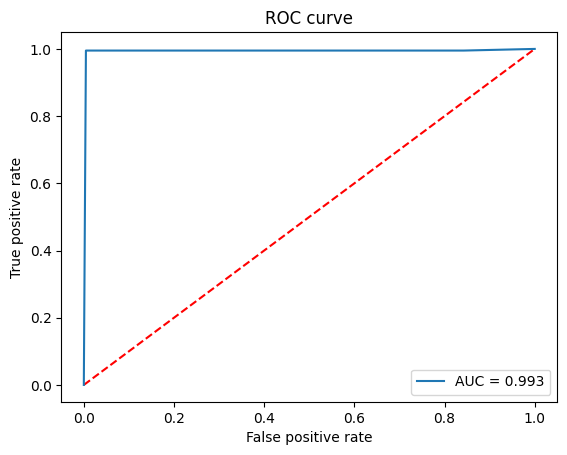

In [23]:
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()
